### .05 Tuned NLP

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime,timedelta
from pathlib import Path
import os
ROOT = Path(__file__).resolve().parents[0] if "__file__" in globals() else Path.cwd()
DATA_DIR = Path(os.getenv("DATA_DIR", ROOT / "data"))  
def p(file): return DATA_DIR / file  

## 1) Purpose & high-level flow

This notebook builds **out-of-fold (OOF)** sentiment features from biotech news headlines using a finance-tuned transformer (FinBERT).  
We then convert probabilities into compact features (logit, margin, entropy) and save them for downstream modeling.

**Pipeline:**
1) Load labeled headlines (`headline`, `label` ∈ {−1, +1})  
2) Add **event flags** (FDA, clinical, financing, M&A, legal) via regex  
3) Train **k-fold** transformer classifiers and collect **OOF probabilities**  
4) Derive calibrated-style features (**logit**, **margin**, **entropy**)  
5) Save everything to `sent_features_oof.parquet`

---

## 2) Imports, warnings, and device

We import NumPy/Pandas for data, PyTorch + HuggingFace for the classifier, and scikit-learn for CV/metrics.  
Warnings are muted for cleaner logs. The runtime picks Apple **MPS** if available, else CPU (shown in the print).

---

## 3) Central configuration (`CFG`)

`CFG` holds all knobs for reproducibility and quick tuning:
- **Paths/columns:** parquet path, text/label names, key IDs (`ticker`, `date`)  
- **Model:** `ProsusAI/finbert` (finance-tuned BERT)  
- **Training:** `N_SPLITS=5`, `MAX_LEN=64`, `EPOCHS=4`, batch sizes, `LR=2e-5`  
- **Outputs:** per-fold output dir  
- **Seed:** fixed for repeatability

---

## 4) Reproducibility helper

`seed_all()` seeds Python, NumPy, and Torch RNGs.  
This reduces variance across runs and lets evaluators recreate the OOF features.

---

## 5) Domain signals: event flags

`event_flags(text)` returns binary indicators for **biotech-specific events**:
- FDA positives/negatives, clinical results, financing, M&A/licensing, legal disputes.  
These interpretable features often interact with model sentiment.

---

## 6) Tokenizer & metrics

- **Tokenizer:** taken from the checkpoint; pad/truncate to `MAX_LEN=64` for efficiency.  
- **Metrics:** report **accuracy** and **ROC-AUC** from validation.  
  Probabilities come from **softmax(logits)** for the positive class.

---
## 7) Load & prepare the dataset

Read `news_with_target_first_hit.parquet`, select/rename columns, keep only labels in {−1,+1}.  
Append **event flags** to each headline for extra explanatory signals.

---

## 8) Label mapping & OOF setup

Map labels {−1,+1} → {0,1}.  
Create an `oof` vector to hold per-row probabilities produced **out-of-fold**.  
Use **StratifiedKFold(k=5)** to keep class balance across splits.

> OOF logic: each sample is scored by a model that **did not** train on it → less bias for downstream models.

---

## 9) Fold loop: build HF datasets

For each fold:
- Build minimal **HF Datasets** for train/val with the columns needed  
- Tokenize text to `input_ids/attention_mask`, attach integer `labels`  
This keeps memory/lightweight data flow and avoids accidental leakage.

---

## 10) Model initialization

Load `AutoModelForSequenceClassification` from **FinBERT** with 2 classes.  
Provide `id2label/label2id` for clarity in logs and move the model to the selected device.

---

## 11) Training configuration

`TrainingArguments` set learning rate, epochs, batch sizes, weight decay, output dir, and seed.  
`report_to="none"` keeps the console clean.

---



In [ ]:
from pathlib import Path
from typing import Dict
import os, logging, random, re, gc, warnings
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from datasets import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from transformers.utils.logging import set_verbosity_error
VERBOSE = False
def _log(*a, **k):
    if VERBOSE:
        print(*a, **k)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["HF_DATASETS_OFFLINE"] = os.environ.get("HF_DATASETS_OFFLINE", "")  
os.environ["WANDB_DISABLED"] = "true"

set_verbosity_error()
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("datasets").setLevel(logging.ERROR)
logging.getLogger("filelock").setLevel(logging.ERROR)

warnings.filterwarnings("ignore", message=r".*Error displaying widget.*")
warnings.filterwarnings("ignore", message=r".*pin_memory.*MPS.*")
warnings.filterwarnings("ignore", category=FutureWarning)

device = "mps" if torch.backends.mps.is_available() else "cpu"
_log(f"Running on ➜ {device.upper()}")

class CFG:
    DATA_PATH   = Path("final_hit__.parquet")
    TEXT_COL    = "headline"
    LABEL_COL   = "label"         
    KEY_COLS    = ["ticker", "date"]
    MODEL_NAME  = "ProsusAI/finbert"
    N_SPLITS    = 5
    MAX_LEN     = 64
    EPOCHS      = 4
    BATCH_TRAIN = 16
    BATCH_VAL   = 32
    LR          = 2e-5
    OUTPUT_DIR  = Path("evt_clf_kfold")
    SEED        = 42

def seed_all(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def event_flags(text: str) -> Dict[str, int]:
    t = text.lower()
    patt = lambda p: bool(re.search(p, t))
    return dict(
        ev_fda_pos = int(patt(r"\bfda (approves|clears|grants|accepts|greenlights)\b")),
        ev_fda_neg = int(patt(r"\bfda (halts|clinical hold|issues.+crl|rejects?)\b")),
        ev_clin_pos= int(patt(r"phase [1-4].*(positive results|met (primary|key) endpoint)")),
        ev_clin_neg= int(patt(r"phase [1-4].*(negative results|missed|failed)")),
        ev_financing = int(patt(r"(secondary offering|follow-on offering|atm program|public offering)")),
        ev_mna       = int(patt(r"\b(acquires?|acquisition|licensing deal|merger|buyout)\b")),
        ev_legal     = int(patt(r"\b(lawsuit|litigation|markman|injunction|patent dispute)\b")),
    )


seed_all(CFG.SEED)

tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token or tokenizer.cls_token

def tok(batch):
    return tokenizer(
        batch[CFG.TEXT_COL],
        truncation=True,
        padding="max_length",
        max_length=CFG.MAX_LEN,
    )

def hf_metrics(pred):
    logits, labels = pred
    probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    return {
        "accuracy": accuracy_score(labels, logits.argmax(-1)),
        "roc_auc" : roc_auc_score(labels, probs),
    }

df = pd.read_parquet(CFG.DATA_PATH)
df = (
    df[CFG.KEY_COLS + ["all_titles", "target_hit"]]
      .rename(columns={"all_titles": CFG.TEXT_COL, "target_hit": CFG.LABEL_COL})
)
df = df[df[CFG.LABEL_COL].isin([-1, 1])].reset_index(drop=True)
_log(f"Loaded {len(df):,} rows")

df = pd.concat([df, df[CFG.TEXT_COL].apply(event_flags).apply(pd.Series)], axis=1)

label2id = {-1: 0, 1: 1}
id2label = {0: "-1", 1: "1"}

oof = np.zeros(len(df))
cv = StratifiedKFold(CFG.N_SPLITS, shuffle=True, random_state=CFG.SEED)

for fold, (tr_idx, va_idx) in enumerate(cv.split(df, df[CFG.LABEL_COL])):
    _log(f"— Fold {fold + 1}/{CFG.N_SPLITS}")

    def make_ds(idx):
        sub = df.iloc[idx][[CFG.TEXT_COL, CFG.LABEL_COL]].copy()
        sub["labels"] = sub[CFG.LABEL_COL].map(label2id)
        ds = Dataset.from_dict({
            CFG.TEXT_COL: sub[CFG.TEXT_COL].tolist(),
            "labels":     sub["labels"].tolist(),
        })
        ds = ds.map(lambda b: tok(b), batched=True)
        return ds

    ds_tr, ds_va = make_ds(tr_idx), make_ds(va_idx)

    model = AutoModelForSequenceClassification.from_pretrained(
        CFG.MODEL_NAME,
        num_labels=2,
        id2label=id2label,
        label2id={str(k): v for k, v in label2id.items()},
        ignore_mismatched_sizes=True,  # keep, but silence its logs
    ).to(device)

    args = TrainingArguments(
        output_dir = CFG.OUTPUT_DIR / f"fold_{fold}",
        learning_rate = CFG.LR,
        per_device_train_batch_size = CFG.BATCH_TRAIN,
        per_device_eval_batch_size = CFG.BATCH_VAL,
        num_train_epochs = CFG.EPOCHS,
        weight_decay = 0.01,
        seed = CFG.SEED,
        # Silence everything:
        report_to = "none",
        disable_tqdm = True,
        logging_strategy = "no",
        #evaluation_strategy = "no",
        save_strategy = "no",
        dataloader_pin_memory = False,   
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_tr,
        eval_dataset=ds_va,
        compute_metrics=hf_metrics,
    )
    trainer.train()

    logits = trainer.predict(ds_va).predictions
    oof[va_idx] = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()

    del model, trainer, ds_tr, ds_va, logits
    gc.collect()
    try:
        torch.cuda.empty_cache()
    except Exception:
        pass

df["nlp_p_pos_oof"] = oof

eps = 1e-8
p = df["nlp_p_pos_oof"].clip(eps, 1 - eps)

df["nlp_logit"]   = np.log(p / (1 - p))
df["nlp_margin"]  = (p - 0.5).abs()
df["nlp_entropy"] = -(p * np.log(p) + (1 - p) * np.log(1 - p))

feat_cols = (
    CFG.KEY_COLS +
    ["nlp_p_pos_oof", "nlp_logit", "nlp_margin", "nlp_entropy"] +
    [c for c in df.columns if c.startswith("ev_")]
)

df[feat_cols].to_parquet("sent_features_oof.parquet", index=False)

if VERBOSE:
    print("Saved ➜ sent_features_oof.parquet", df[feat_cols].shape)

## 12) Train, evaluate, and collect OOF predictions

Create a `Trainer` with model, args, datasets, and metric fn.  
After `trainer.train()`:
- Call `trainer.predict(ds_va)` to get **validation logits**  
- Convert to positive-class probabilities via softmax and store them into `oof[va_idx]`  
Free memory to keep the loop stable.

> This step guarantees the stored probability for each row is **strictly OOS** for that fold.

---

## 13) Attach OOF scores

Write the collected probabilities to `df["nlp_p_pos_oof"]`.  
This column is the model’s estimated `P(label = +1)` for each headline.

---

## 14) Derive compact probability features

From `p = nlp_p_pos_oof` we compute:
- **Logit:** `log(p/(1−p))` → linearizes odds, good for linear models  
- **Margin:** `|p − 0.5|` → confidence proxy (distance from indecision)  
- **Entropy:** `−[p log p + (1 − p) log(1 − p)]` → uncertainty (lower = more certain)  
Use `eps=1e-8` to avoid numerical issues at 0/1.

---

## 15) Save the final feature set

Persist the keys (`ticker`, `date`), **OOF features** (`nlp_p_pos_oof`, `nlp_logit`, `nlp_margin`, `nlp_entropy`), and all `ev_*` flags to  
**`sent_features_oof.parquet`**. Print the saved shape for traceability.

In [2]:
nlp = pd.read_parquet(p('sent_features_oof.parquet'))

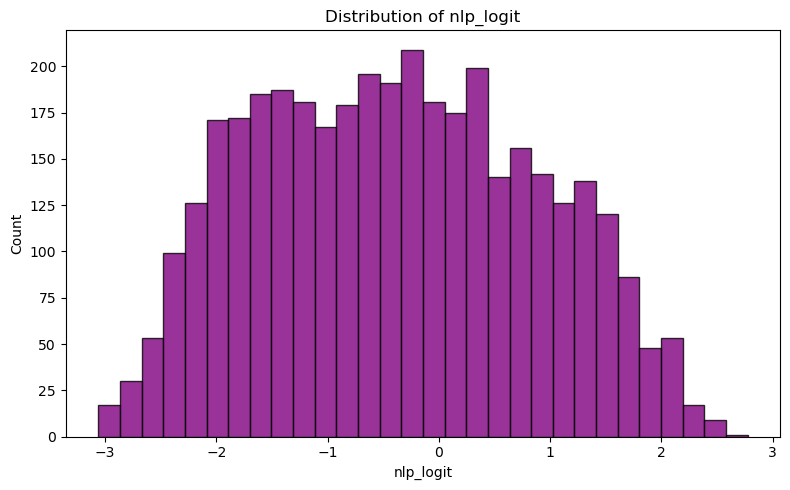

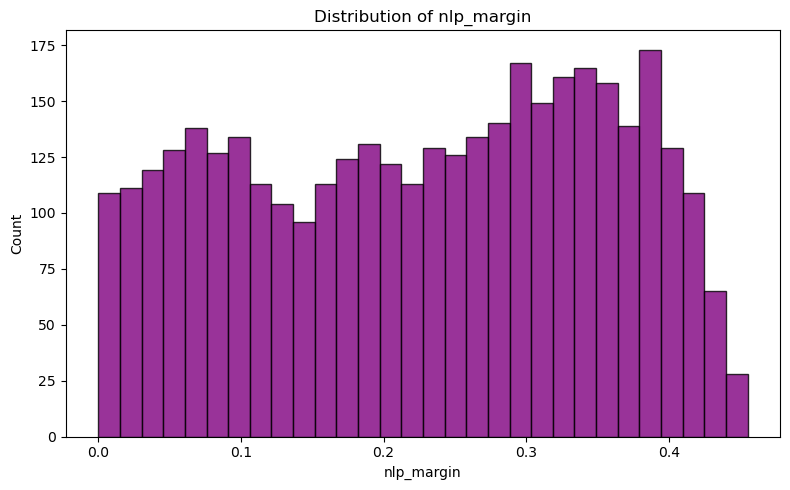

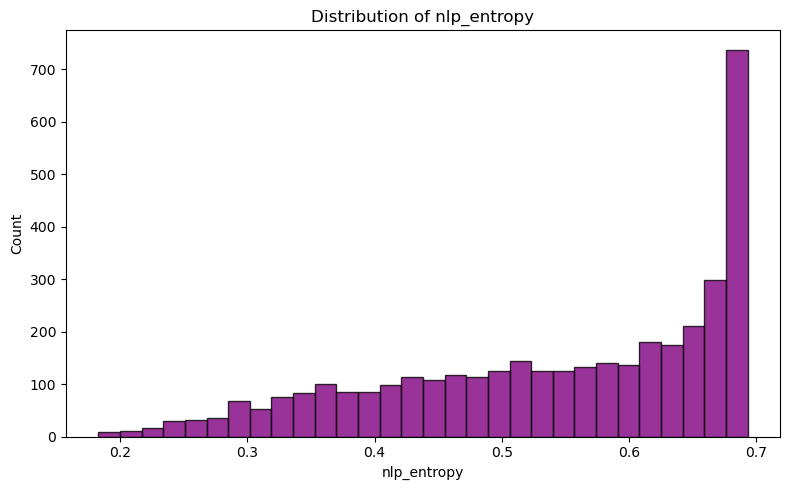

In [3]:
import matplotlib.pyplot as plt
for col in ["nlp_logit", "nlp_margin", "nlp_entropy"]:
    plt.figure(figsize=(8,5))
    plt.hist(nlp[col], bins=30,color = 'purple', edgecolor="black", alpha=0.8)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

## Distributions of NLP-derived features (logit, margin, entropy)

**What you see**
- **`nlp_logit`** (top): roughly bell-shaped, spanning ~[−3, +3], slightly tilted to the negative side.  
- **`nlp_margin`** (middle): spread between ~0.00 and ~0.45 with a mild concentration toward **0.25–0.40**.  
- **`nlp_entropy`** (bottom): strongly skewed toward the upper bound **(~0.69)**, with a thinner tail to lower values.

**How to read it**
- `logit` near **0** ⇒ the model is uncertain (p≈0.5). Negative logits ⇒ bias toward the negative class; positive ⇒ toward the positive class.
- `margin` measures **confidence** (distance from 0.5). The mass around **0.25–0.40** indicates many predictions are moderately confident; very small margins are less common.
- `entropy` peaks near **0.69**, the max for a binary classifier (p=0.5). This confirms that **most headlines are hard** (model close to indifferent), with fewer “easy” cases (low entropy).

**Takeaways**
- The signal is present but **not extreme**; most probabilities sit near 0.5 with a useful minority of confident cases.
- Downstream, focus on **top-decile** usage (e.g., precision in highest-confidence bins) and **calibration** rather than raw accuracy alone.

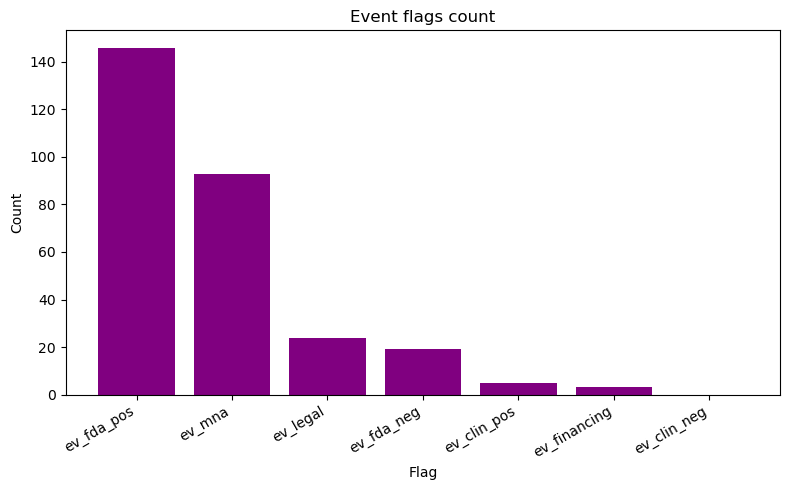

In [4]:

ev_cols = [c for c in nlp.columns if c.startswith("ev_")]
ev_counts = nlp[ev_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
plt.bar(ev_counts.index, ev_counts.values,color = 'purple')
plt.title("Event flags count")
plt.xlabel("Flag")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

## Event flags — frequency profile

**Counts (descending)**  
`ev_fda_pos` is the most frequent, followed by `ev_mna`. Then much smaller buckets: `ev_legal`, `ev_fda_neg`, `ev_clin_pos`, `ev_financing`, and (near zero) `ev_clin_neg`.

**Interpretation**
- The dataset is **dominated by positive FDA headlines** and **M&A/licensing**; true adverse clinical/FDA events and financings are comparatively **rare**.
- This imbalance means models can easily **overfit to frequent events** and underperform on scarce but impactful negatives.

___________________________________________
___________________________________________
___________________________________________

### MERGE , AND PREPARING FOR BIVARIATE ANALYSIS

In [5]:
import pandas as pd

In [6]:
ml = pd.read_parquet(p("final_hit__.parquet"))

In [7]:
ml = ml[ml['target_hit'] != 0]

In [8]:
dups = (nlp
        .sort_values(['ticker','date'])
        .groupby(['ticker','date'])
        .size()
        .loc[lambda s: s>1])

print("Ticker-date duplicated:", len(dups))
print(dups.head())

Ticker-date duplicated: 489
ticker  date      
AARD    2025-02-13    2
ABCL    2025-05-30    2
        2025-06-02    2
ABSI    2025-01-08    2
ACIU    2024-08-06    2
dtype: int64


In [9]:
agg_dict = {
    
    'nlp_p_pos_oof': 'mean',
    'nlp_logit'    : 'mean',
    'nlp_margin'   : 'mean',
    'nlp_entropy'  : 'mean',
    
    'ev_fda_pos'   : 'max',
    'ev_fda_neg'   : 'max',
    'ev_clin_pos'  : 'max',
    'ev_financing' : 'max',
    'ev_mna'       : 'max',
    'ev_legal'     : 'max',
}

nlp_agg = (nlp
           .groupby(['ticker','date'], as_index=False)
           .agg(agg_dict))


df = ml.merge(
        nlp_agg,
        on=['ticker','date'],
        how='left',
        validate='m:1'    
)

In [10]:
num_cols  = ml.select_dtypes(float).columns.difference(['finroberta_neg',
                                                        'finroberta_neu',
                                                        'finroberta_pos',
                                                        'finroberta_compound'])
mean_dict = {c: 'mean'  for c in num_cols}
frb_dict  = {  
    'finroberta_neg': 'mean',
    'finroberta_neu': 'mean',
    'finroberta_pos': 'mean',
    'finroberta_compound': 'mean',
}
first_cols = ['target_hit']      
first_dict = {c: 'first' for c in first_cols}

ml_agg = (ml
          .groupby(['ticker','date'], as_index=False)
          .agg({**mean_dict, **frb_dict, **first_dict}))

df = ml_agg.merge(
        nlp_agg,
        on=['ticker','date'],
        how='left',
        validate='1:1'
)

In [11]:
df.info()
df.to_parquet('ML.parquet')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2967 entries, 0 to 2966
Data columns (total 90 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ticker                       2967 non-null   object        
 1   date                         2967 non-null   datetime64[ns]
 2   Accel_diff_XBI_IBB           2967 non-null   float64       
 3   BAA                          2967 non-null   float64       
 4   DGS10                        2967 non-null   float64       
 5   DGS2                         2967 non-null   float64       
 6   DGS3MO                       2967 non-null   float64       
 7   DTWEXBGS                     2967 non-null   float64       
 8   DXY_chg_20d                  2967 non-null   float64       
 9   DXY_chg_5d                   2967 non-null   float64       
 10  DXY_z                        2967 non-null   float64       
 11  HY_OAS_bp                    2967 non-null 